In [1]:
!pip install datasets transformers evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.2 MB/s eta 0:00:00


In [72]:
import numpy  as np
import pandas as pd
from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import losses
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy

In [3]:
# read test and trian data and use Dataset library
data = DatasetDict()
df_train = pd.read_csv("/content/train_related.csv", usecols = ['Record_text', 'InRelationship','General_comment_binary','General_comment','Specific_comment_binary','Specific_comment','Comment','Relevance'], on_bad_lines='skip')
df_train = df_train.rename(columns={'InRelationship': 'label'})


data_classes_ = [-1,0,1]
d=dict(zip(data_classes_, range(0,3)))
df_train['label']=df_train['label'].map(d, na_action='ignore')
weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(df_train.label),
                                        y = df_train.label
                                 )

In [4]:
data['train'] = Dataset.from_pandas(df_train)

df_test = pd.read_csv("/content/test_related.csv", usecols = ['Record_text', 'InRelationship','General_comment_binary','General_comment','Specific_comment_binary','Specific_comment','Comment','Relevance'], on_bad_lines='skip')
df_test = df_test.rename(columns={'InRelationship': 'label'})
df_test['label']=df_test['label'].map(d, na_action='ignore')


df_test_unfreeze=df_test.copy()
df_test_unfreeze_11=df_test.copy()
df_test_freeze=df_test.copy()

data['test'] = Dataset.from_pandas(df_test)

In [8]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

In [9]:
# Tokenization function
def tokenize(batch):
    return tokenizer(batch["Record_text"], padding=True, truncation=True, max_length = 50)
# Tokenize entire dataset
tokenized_dataset = data.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/5540 [00:00<?, ? examples/s]

Map:   0%|          | 0/1225 [00:00<?, ? examples/s]

In [10]:
#Select mode of model
def freeze(model,mode):
    if mode=='unfreeze':
       for layer in model.get_layer('bert').encoder.layer:
            print(f"{layer.name}: {layer.trainable}")
    elif mode=='unfreeze_11':
       for layer in model.layers:
           layer.trainable = False
       model.get_layer('bert').encoder.layer[11].trainable=True  #11
       model.layers[-1].trainable = True   #12
       for layer in model.get_layer('bert').encoder.layer:
           print(f"{layer.name}: {layer.trainable}")
    else:
       for layer in model.layers:
           layer.trainable = False
       model.layers[-1].trainable = True  #12
       for layer in model.get_layer('bert').encoder.layer:
           print(f"{layer.name}: {layer.trainable}")
    return model

In [11]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [13]:
# Create tf datasets
BAtch_Size = 64
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns= ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    label_cols=["label"],
    shuffle=True,
    batch_size=BAtch_Size,
    collate_fn=data_collator
)
tf_valid_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    label_cols=["label"],
    shuffle=False,
    batch_size=BAtch_Size,
    collate_fn=data_collator
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [14]:
def compile(model):
  # Compile the model
  model.compile(
    optimizer=optimizers.Adam(learning_rate=9e-5),
    loss=model.hf_compute_loss,
    metrics=metrics.SparseCategoricalAccuracy()
)
  return model

In [16]:
# Training_function
def training(model,Epoch,weights):
    EPOCHS = Epoch
    checkpoint_filepath = '/content/"training\cp.ckpt" '
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    # Model weights are saved at the end of every epoch, if it's the best seen
    # so far.
    # Fit the model

    history = model.fit(tf_train_dataset,
              validation_data=tf_valid_dataset,
              epochs=EPOCHS,class_weight=weights)
             # callbacks=[model_checkpoint_callback])

In [17]:
weights=dict(enumerate(weights, 0))
weights

{0: 0.6253527486172255, 1: 7.021546261089988, 2: 0.7946069994262766}

In [19]:
#Mode
mode=['unfreeze','unfreeze_11','freeze']


## Mode: Un-freeze

In [52]:
num_labels=3
model_ = TFAutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",
                                                             num_labels=num_labels,
                                                            id2label={0: 'unknown', 1: 'Single',2:'married'})

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:

model_=freeze(model_,mode[0])

layer_._0: True
layer_._1: True
layer_._2: True
layer_._3: True
layer_._4: True
layer_._5: True
layer_._6: True
layer_._7: True
layer_._8: True
layer_._9: True
layer_._10: True
layer_._11: True


In [54]:
#Compile
model_=compile(model_)

---------------------------------------------------------------------------------------------Training-------------------------------------------------------------------------------------------------------------





#### 3,more than 3 epoch --------->overfitt
#### Epoch = 3

In [55]:
training(model_,3,weights)

Epoch 1/3
87/87 [==============================] - 106s 672ms/step - loss: 0.8846 - sparse_categorical_accuracy: 0.6186 - val_loss: 0.7069 - val_sparse_categorical_accuracy: 0.6849
Epoch 2/3
87/87 [==============================] - 56s 642ms/step - loss: 0.6567 - sparse_categorical_accuracy: 0.7395 - val_loss: 0.6800 - val_sparse_categorical_accuracy: 0.7592
Epoch 3/3
87/87 [==============================] - 57s 657ms/step - loss: 0.4011 - sparse_categorical_accuracy: 0.8384 - val_loss: 0.7126 - val_sparse_categorical_accuracy: 0.7763


---------------------------------------------------------------------------------------------Evaluate_model-------------------------------------------------------------------------------------------------------------

In [73]:
def pred_label(text):
    inputs = tokenizer(text, return_tensors="tf")
    logits =  model_(inputs).logits
    #logits =  model_unfreeze_11(inputs).logits
    # logits =  model_freeze(inputs).logits
      # print(logits)
    predict = int(tf.math.argmax(logits, axis=-1)[0])
      # print(predict)
    return predict
def Evaluate_models(df_test,model,label,mode):
    print(f":::::::::::::::Performance of ParsBERT'{mode}' on '{label}' Label:::::::::::::::::::")
    df_test["pred_label"]= df_test["Record_text"].apply(lambda x:pred_label(x))
    Real_label = df_test["label"].values
    predictions = df_test["pred_label"].values
    accuracy = accuracy_score(Real_label, predictions)
    print(classification_report(Real_label, predictions, labels=[0, 1,2], zero_division=0))
        #accuracy = accuracy_score(y_test, preds[i])
    print(f'''Accuracy: {round(accuracy_score(Real_label, predictions, normalize=True),6)}
    \nPrecision:{round(precision_score(Real_label, predictions, average='macro'),6)}
    \nRecall: {round(recall_score(Real_label, predictions, average='macro'),6)}
    \nF1 score: {round(f1_score(Real_label, predictions, average='macro'),6)}''')
    print('\n')
    print('\n')
    print('\n')
    print('-----------------------------------------------------------------------------------------------------------')
    print('-----------------------------------------------------------------------------------------------------------')
    confusion_matrix = metrics.confusion_matrix(Real_label, predictions)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1,2])
    cm_display.plot()
    plt.show()
    return df_test

:::::::::::::::Performance of ParsBERT'unfreeze' on 'In_Relationship' Label:::::::::::::::::::
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       650
           1       0.21      0.27      0.24        51
           2       0.84      0.68      0.75       524

    accuracy                           0.78      1225
   macro avg       0.61      0.62      0.61      1225
weighted avg       0.79      0.78      0.78      1225

Accuracy: 0.77551
    
Precision:0.613057
    
Recall: 0.615526
    
F1 score: 0.60934






-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------


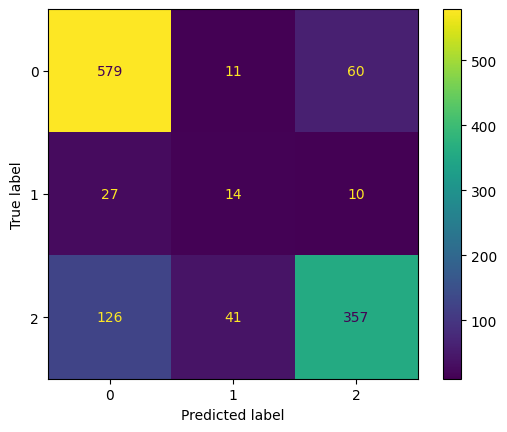

,Record_text,label,General_comment_binary,General_comment,Specific_comment_binary,Specific_comment,Comment,Relevance,pred_label
0,حالا در مورد زید یه خاکی بریز شوهر شد دوبار خا...,0,1,1,0.0,3,احتمالا زید یه جیزی بوده که نوشته یه خاکی بریز,1,0
1,: دوست پسر من باید مثل خودم کاسب باشه یعنی چی ...,2,1,1,1.0,1,دوست پسرش بهش پیام داده بریم بیرون اما این خوش...,1,0
2,: ولی نمیشه خانوم ها تا شوهر کنن چهار به یک چ...,0,1,0,0.0,3,اینکه خانما الان یدونه شوهر میتونن داشته باشن،...,1,0
3,من یکی از فانتزی هام اینکه اگه ازدواج کردم همس...,1,1,0,0.0,3,این تبارها از نظر این شخص گزینه خوبی برای ازدو...,1,2
4,یه بحران دیگه داریم که به نظر بحران اصلی اونه:...,1,1,1,0.0,3,حرف ازدواج اصلا نزن,1,0
...,...,...,...,...,...,...,...,...,...
1220,از اونجایی که همه چیز دو طرفست، وقتی راضی نیست...,2,1,2,1.0,2,کامنت,1,0
1221,خفه شو بابا برو زنتو جمع کن از دست فرانسوی ها ...,0,1,1,0.0,3,کامنت,1,0
1222,خیانت ربطی به زیبایی پارتنر طرف نداره بلکه به ...,0,1,1,0.0,3,کامنت,1,0
1223,به زنم این دریافتم را گفتم. اون هم خوب که درمو...,2,1,2,1.0,2,کامنت,1,0


In [58]:
Evaluate_models(df_test_unfreeze,model_,'In_Relationship',mode[0])

----------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df_test_unfreeze_unknown_InRelationship= df_test_unfreeze[(df_test_unfreeze['label'] == 0) & (df_test_unfreeze['pred_label'] == 0)]
df_test_unfreeze_single_InRelationship = df_test_unfreeze[(df_test_unfreeze['label'] == 1) & (df_test_unfreeze['pred_label'] == 1)]
df_test_unfreeze_married_InRelationship = df_test_unfreeze[(df_test_unfreeze['label'] == 2) & (df_test_unfreeze['pred_label'] == 2)]

In [ ]:
df_test_unfreeze_unknown_InRelationship.to_csv('/content/df_test_unfreeze_unknown_InRelationship.csv')
df_test_unfreeze_single_InRelationship.to_csv('/content/df_test_unfreeze_single_InRelationship.csv')
df_test_unfreeze_married_InRelationship.to_csv('/content/df_test_unfreeze_married_InRelationship.csv')

In [ ]:
df_test_unfreeze.to_csv('/content/df_test_unfreeze_InRelationship.csv')


## Mode: Freeze except layer 11


In [60]:
num_labels=3
model_unfreeze_11 = TFAutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",
                                                             num_labels=num_labels,
                                                            id2label={0: 'unknown', 1: 'Single',2:'married'})

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
model_unfreeze_11=freeze(model_unfreeze_11,mode[1])

layer_._0: False
layer_._1: False
layer_._2: False
layer_._3: False
layer_._4: False
layer_._5: False
layer_._6: False
layer_._7: False
layer_._8: False
layer_._9: False
layer_._10: False
layer_._11: True


In [62]:
#Compile
model_unfreeze_11=compile(model_unfreeze_11)

---------------------------------------------------------------------------------------------Training-------------------------------------------------------------------------------------------------------------

#### Epoch =50

In [63]:
training(model_unfreeze_11,50,weights)

Epoch 1/50
87/87 [==============================] - 43s 313ms/step - loss: 1.1048 - sparse_categorical_accuracy: 0.3296 - val_loss: 1.0989 - val_sparse_categorical_accuracy: 0.3616
Epoch 2/50
87/87 [==============================] - 22s 259ms/step - loss: 1.0681 - sparse_categorical_accuracy: 0.4199 - val_loss: 1.0786 - val_sparse_categorical_accuracy: 0.3771
Epoch 3/50
87/87 [==============================] - 23s 260ms/step - loss: 1.0522 - sparse_categorical_accuracy: 0.4455 - val_loss: 1.0255 - val_sparse_categorical_accuracy: 0.5273
Epoch 4/50
87/87 [==============================] - 23s 265ms/step - loss: 1.0327 - sparse_categorical_accuracy: 0.4978 - val_loss: 1.0076 - val_sparse_categorical_accuracy: 0.5437
Epoch 5/50
87/87 [==============================] - 23s 264ms/step - loss: 1.0172 - sparse_categorical_accuracy: 0.5182 - val_loss: 1.0241 - val_sparse_categorical_accuracy: 0.4882
Epoch 6/50
87/87 [==============================] - 23s 264ms/step - loss: 1.0018 - sparse_cate

---------------------------------------------------------------------------------------------Evaluate_model-------------------------------------------------------------------------------------------------------------

:::::::::::::::Performance of ParsBERT'unfreeze_11' on 'InRelationship' Label:::::::::::::::::::
              precision    recall  f1-score   support

           0       0.78      0.66      0.72       650
           1       0.10      0.57      0.17        51
           2       0.71      0.52      0.60       524

    accuracy                           0.60      1225
   macro avg       0.53      0.58      0.49      1225
weighted avg       0.72      0.60      0.64      1225

Accuracy: 0.595918
    
Precision:0.530294
    
Recall: 0.582447
    
F1 score: 0.494518






-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------


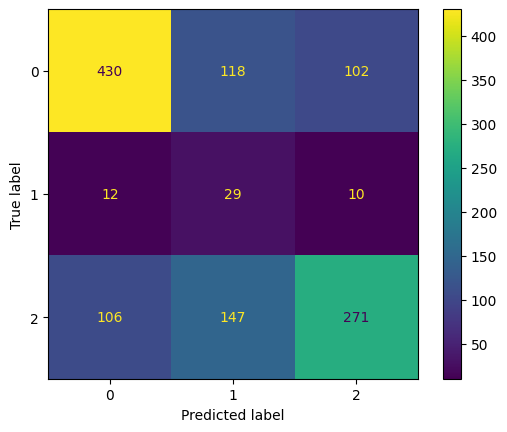

,Record_text,label,General_comment_binary,General_comment,Specific_comment_binary,Specific_comment,Comment,Relevance,pred_label
0,حالا در مورد زید یه خاکی بریز شوهر شد دوبار خا...,0,1,1,0.0,3,احتمالا زید یه جیزی بوده که نوشته یه خاکی بریز,1,2
1,: دوست پسر من باید مثل خودم کاسب باشه یعنی چی ...,2,1,1,1.0,1,دوست پسرش بهش پیام داده بریم بیرون اما این خوش...,1,2
2,: ولی نمیشه خانوم ها تا شوهر کنن چهار به یک چ...,0,1,0,0.0,3,اینکه خانما الان یدونه شوهر میتونن داشته باشن،...,1,0
3,من یکی از فانتزی هام اینکه اگه ازدواج کردم همس...,1,1,0,0.0,3,این تبارها از نظر این شخص گزینه خوبی برای ازدو...,1,1
4,یه بحران دیگه داریم که به نظر بحران اصلی اونه:...,1,1,1,0.0,3,حرف ازدواج اصلا نزن,1,0
...,...,...,...,...,...,...,...,...,...
1220,از اونجایی که همه چیز دو طرفست، وقتی راضی نیست...,2,1,2,1.0,2,کامنت,1,1
1221,خفه شو بابا برو زنتو جمع کن از دست فرانسوی ها ...,0,1,1,0.0,3,کامنت,1,2
1222,خیانت ربطی به زیبایی پارتنر طرف نداره بلکه به ...,0,1,1,0.0,3,کامنت,1,0
1223,به زنم این دریافتم را گفتم. اون هم خوب که درمو...,2,1,2,1.0,2,کامنت,1,0


In [66]:
Evaluate_models(df_test_unfreeze_11,model_unfreeze_11,'InRelationship',mode[1])

---------------------------------------------------------------------------


## Mode: Freeze

In [67]:
num_labels=3
model_freeze = TFAutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",
                                                             num_labels=num_labels,
                                                            id2label={0: 'unknown', 1: 'Single',2:'married'})

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
model_freeze=freeze(model_freeze,mode[2])

layer_._0: False
layer_._1: False
layer_._2: False
layer_._3: False
layer_._4: False
layer_._5: False
layer_._6: False
layer_._7: False
layer_._8: False
layer_._9: False
layer_._10: False
layer_._11: False


In [70]:
#Compile
model_freeze=compile(model_freeze)

---------------------------------------------------------------------------------------------Training-------------------------------------------------------------------------------------------------------------

In [71]:
training(model_freeze,50,weights)

Epoch 1/50
87/87 [==============================] - 43s 301ms/step - loss: 1.1057 - sparse_categorical_accuracy: 0.3670 - val_loss: 1.0890 - val_sparse_categorical_accuracy: 0.3649
Epoch 2/50
87/87 [==============================] - 24s 273ms/step - loss: 1.0678 - sparse_categorical_accuracy: 0.3948 - val_loss: 1.0481 - val_sparse_categorical_accuracy: 0.5110
Epoch 3/50
87/87 [==============================] - 24s 274ms/step - loss: 1.0474 - sparse_categorical_accuracy: 0.4930 - val_loss: 1.0293 - val_sparse_categorical_accuracy: 0.4963
Epoch 4/50
87/87 [==============================] - 23s 264ms/step - loss: 1.0327 - sparse_categorical_accuracy: 0.4856 - val_loss: 1.0218 - val_sparse_categorical_accuracy: 0.5265
Epoch 5/50
87/87 [==============================] - 23s 263ms/step - loss: 1.0164 - sparse_categorical_accuracy: 0.5188 - val_loss: 1.0071 - val_sparse_categorical_accuracy: 0.5029
Epoch 6/50
87/87 [==============================] - 23s 268ms/step - loss: 1.0047 - sparse_cate

---------------------------------------------------------------------------------------------Evaluate_model-------------------------------------------------------------------------------------------------------------

:::::::::::::::Performance of ParsBERT'freeze' on 'InRelationship' Label:::::::::::::::::::
              precision    recall  f1-score   support

           0       0.78      0.66      0.72       650
           1       0.12      0.53      0.19        51
           2       0.69      0.59      0.63       524

    accuracy                           0.62      1225
   macro avg       0.53      0.59      0.51      1225
weighted avg       0.71      0.62      0.66      1225

Accuracy: 0.62449
    
Precision:0.529385
    
Recall: 0.592912
    
F1 score: 0.514868






-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------


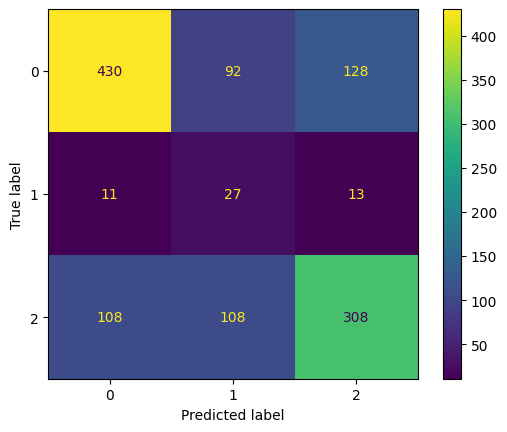

,Record_text,label,General_comment_binary,General_comment,Specific_comment_binary,Specific_comment,Comment,Relevance,pred_label
0,حالا در مورد زید یه خاکی بریز شوهر شد دوبار خا...,0,1,1,0.0,3,احتمالا زید یه جیزی بوده که نوشته یه خاکی بریز,1,2
1,: دوست پسر من باید مثل خودم کاسب باشه یعنی چی ...,2,1,1,1.0,1,دوست پسرش بهش پیام داده بریم بیرون اما این خوش...,1,2
2,: ولی نمیشه خانوم ها تا شوهر کنن چهار به یک چ...,0,1,0,0.0,3,اینکه خانما الان یدونه شوهر میتونن داشته باشن،...,1,0
3,من یکی از فانتزی هام اینکه اگه ازدواج کردم همس...,1,1,0,0.0,3,این تبارها از نظر این شخص گزینه خوبی برای ازدو...,1,1
4,یه بحران دیگه داریم که به نظر بحران اصلی اونه:...,1,1,1,0.0,3,حرف ازدواج اصلا نزن,1,0
...,...,...,...,...,...,...,...,...,...
1220,از اونجایی که همه چیز دو طرفست، وقتی راضی نیست...,2,1,2,1.0,2,کامنت,1,1
1221,خفه شو بابا برو زنتو جمع کن از دست فرانسوی ها ...,0,1,1,0.0,3,کامنت,1,2
1222,خیانت ربطی به زیبایی پارتنر طرف نداره بلکه به ...,0,1,1,0.0,3,کامنت,1,0
1223,به زنم این دریافتم را گفتم. اون هم خوب که درمو...,2,1,2,1.0,2,کامنت,1,0


In [74]:
Evaluate_models(df_test_freeze,model_freeze,'InRelationship',mode[2])